In [1]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import (
    resnet50, vgg16, efficientnet_b0, mobilenet_v2, shufflenet_v2_x0_5, squeezenet1_0)
from torchvision.models import (
    ResNet50_Weights, VGG16_Weights, EfficientNet_B0_Weights, MobileNet_V2_Weights,
    ShuffleNet_V2_X0_5_Weights, SqueezeNet1_0_Weights)
# import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
import tensorflow as tf

import tensorflow_hub as hub
# from efficientnet_lite import EfficientNetLiteB0
from scipy.spatial.distance import cosine
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
%matplotlib inline



2024-12-09 20:05:20.896269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 20:05:20.916808: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU


print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [3]:
import logging
import tensorflow as tf
import os

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Configure TensorFlow logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)
tf.debugging.set_log_device_placement(True)

# Perform a computation
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
c = tf.matmul(a, b)
print(c)


input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:CPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
a: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
b: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
MatMul: (MatMul): /job:localhost/replica:0/task:0/device:CPU:0
product_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
a: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
b: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
_MklMatMul: (_MklMatMul): /job:localhost/replica:0/task:0/device:CPU:0
product_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
Executing op _MklMatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=floa

2024-12-09 20:05:38.695550: I tensorflow/core/common_runtime/placer.cc:162] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:05:38.695570: I tensorflow/core/common_runtime/placer.cc:162] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:05:38.695574: I tensorflow/core/common_runtime/placer.cc:162] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:05:38.700511: I tensorflow/core/common_runtime/placer.cc:162] a: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:05:38.700524: I tensorflow/core/common_runtime/placer.cc:162] b: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:05:38.700528: I tensorflow/core/common_runtime/placer.cc:162] MatMul: (MatMul): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:05:38.700531: I tensorflow/core/common_runtime/placer.cc:162] product_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:05:

In [143]:

print(tf.__version__)


2.18.0


In [4]:
# Function to display an image
def show_image(image_path, title="Image"):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Function to display grayscale images
def show_grayscale_image(image, title="Grayscale Image"):
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Function to display SIFT matches
def show_sift_matches(image1_path, image2_path, kp1, kp2, matches):
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    match_img = cv2.drawMatches(
        img1, kp1, img2, kp2, matches[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(match_img)
    plt.title("SIFT Matches")
    plt.axis("off")
    plt.show()


In [5]:
# Compute SSIM
def compute_ssim(image1_path, image2_path):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize to ensure consistent dimensions
    img1 = cv2.resize(img1, (256, 256))
    img2 = cv2.resize(img2, (256, 256))
    
    show_grayscale_image(img1, title="Grayscale Image 1 for SSIM")
    show_grayscale_image(img2, title="Grayscale Image 2 for SSIM")
    
    similarity, _ = ssim(img1, img2, full=True)
    return similarity

# Compute SIFT Matches
def sift_similarity(image1_path, image2_path):
    sift = cv2.SIFT_create()
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    if des1 is None or des2 is None:
        return 0, 0, 0, [], [], []
    
    # Match descriptors using FLANN
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    return len(good_matches), len(kp1), len(kp2), kp1, kp2, good_matches



def compute_cosine_similarity(features1, features2):
    return 1 - cosine(features1, features2)





In [6]:
# Define the transformation pipeline
pytorch_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# # Define transformations for PyTorch models
# pytorch_transform = Compose([
#     ToTensor(),
#     Resize((224, 224)),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Preprocess image for PyTorch
def preprocess_pytorch_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = pytorch_transform(img).unsqueeze(0)
    return img

# # Preprocess image for TensorFlow
# def preprocess_tf_image(image_path, target_size=(224, 224)):
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, target_size) / 255.0
#     return np.expand_dims(img, axis=0)

def preprocess_tf_image(image_path, target_size=(224, 224)):
    # import cv2
    # import numpy as np

    # Load and convert the image
    img = cv2.imread(image_path)  # Load image in BGR format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    # Resize to target size (224x224)
    img = cv2.resize(img, target_size)

    # Normalize pixel values to [0, 1] range
    img = img / 255.0

    # Add batch dimension: shape (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0).astype(np.float32)

    return img

# # Feature extraction
# def extract_features(image_path, pytorch_models, tf_models):
#     print("Extracting features with PyTorch models...")
#     for model_name, model in pytorch_models.items():
#         model.eval()
#         with torch.no_grad():
#             input_tensor = preprocess_pytorch_image(image_path)
#             features = model(input_tensor)
#             print(f"{model_name} Features Shape: {features.shape}")

#     print("\nExtracting features with TensorFlow models...")
#     for model_name, model in tf_models.items():
#         input_tensor = preprocess_tf_image(image_path)
#         features = model(input_tensor)
#         print(f"{model_name} Features Shape: {features.shape}")

# # Extract features using deep learning models
# def extract_features_dl(image_path, model, transform):
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img_tensor = transform(img).unsqueeze(0)
#     with torch.no_grad():
#         features = model(img_tensor)
#     return features.squeeze().numpy()

In [100]:
# # Load EfficientNet-Lite from TensorFlow Hub
# efficientnet_lite_b0 = hub.KerasLayer(
#         "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2",
#         input_shape=(224, 224, 3)
#     )

In [7]:
# Load pretrained models
def load_models():
    # PyTorch models
    pytorch_models = {
        "ResNet50": resnet50(weights=ResNet50_Weights.DEFAULT),
        "VGG16": vgg16(weights=VGG16_Weights.DEFAULT),
        "EfficientNet_B0": efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT),
        "MobileNet": mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT),
        "ShuffleNet": shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.DEFAULT),
        "SqueezeNet": squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT),
    }
    
    # TensorFlow EfficientNet-Lite model from TensorFlow Hub
    efficientnet_lite_b0 = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2",
        trainable=False  # Ensure the model is in inference mode
    )
    
    tf_models = {
        "EfficientNet-Lite": efficientnet_lite_b0
    }
    
    return pytorch_models, tf_models

# Call load_models to initialize both PyTorch and TensorFlow models
pytorch_models, tf_models = load_models()

resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
VarHandleOp: (VarHandle

2024-12-09 20:06:04.273722: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.273746: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.275916: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.275931: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.276780: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.276791: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.277571: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:CPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
save_const_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
efficientnet_lite0_stem_conv2d_kernel: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
efficientnet_lite0_stem_tpu_batch_normalization_gamma: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
efficientnet_lite0_stem_tpu_batch_normalization_beta: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
efficientnet_lite0_stem_tpu_batch_normalization_moving_mean: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
efficientnet_lite0_stem_tpu_batch_normalization_moving_variance: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
efficientnet_lite0_blocks_0_depthwise_conv2d_depthwise_kernel: (_Arg): /job:localhost/replica:0/task:0/device:

2024-12-09 20:06:04.569178: I tensorflow/core/common_runtime/placer.cc:162] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.569195: I tensorflow/core/common_runtime/placer.cc:162] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.569198: I tensorflow/core/common_runtime/placer.cc:162] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.578356: I tensorflow/core/common_runtime/placer.cc:162] save_const_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.578372: I tensorflow/core/common_runtime/placer.cc:162] efficientnet_lite0_stem_conv2d_kernel: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.578375: I tensorflow/core/common_runtime/placer.cc:162] efficientnet_lite0_stem_tpu_batch_normalization_gamma: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2024-12-09 20:06:04.578378: I tensorflow/core/common_runtime/placer.cc:16

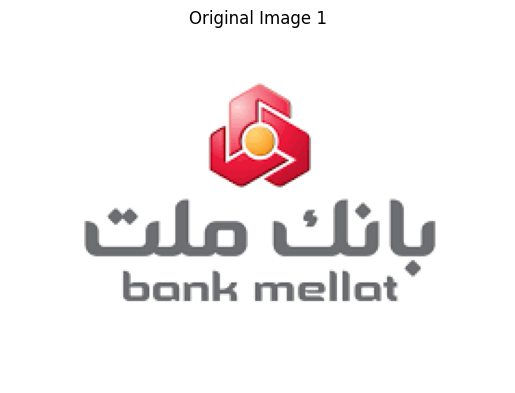

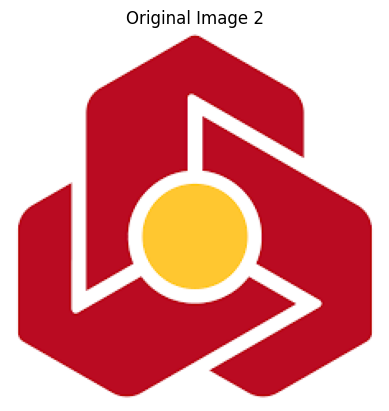

In [40]:
# img1= 'bankmellat_pic3.jpeg'
# img2 = 'bankghavamin_pic7.jpg'
img1= 'bankmellat_pic1.png'
# img2= 'banktejarat_pic8.png'
# img1= 'cat.jpg'
# img2= 'flower.jpg'
# img1 = 'mellal.png'
# img2 = 'bankmellat_pic6.jpeg'
img2= 'bankmellat_pic5.png'

img1_path = f"/home/mahdi/Phishing_Project/images/{img1}"
img2_path = f"/home/mahdi/Phishing_Project/images/{img2}"


show_image(img1_path, title="Original Image 1")
show_image(img2_path, title="Original Image 2")


In [41]:
# Extract features and compute cosine similarity
def compute_similarity(img1_path, img2_path, pytorch_models, tf_models, pytorch_transform):
    print("\n### PyTorch Models ###")
    for name, model in pytorch_models.items():
        model.eval()
        with torch.no_grad():
            # Preprocess images
            img1 = preprocess_pytorch_image(img1_path)
            img2 = preprocess_pytorch_image(img2_path)
            # img1 = preprocess_pytorch_image(img1_path, pytorch_transform)
            # img2 = preprocess_pytorch_image(img2_path, pytorch_transform)
            # Extract features
            features1 = model(img1).squeeze().numpy()
            features2 = model(img2).squeeze().numpy()

            # Compute cosine similarity
            similarity = compute_cosine_similarity(features1, features2)
            print(f"{name} Cosine Similarity: {similarity:.4f}")

    print("\n### TensorFlow Models ###")
    for name, model in tf_models.items():
        # Preprocess images
        img1 = preprocess_tf_image(img1_path)
        img2 = preprocess_tf_image(img2_path)

        # # Debugging prints
        # print(f"{name}: Image 1 Shape: {img1.shape}, Dtype: {img1.dtype}")
        # print(f"{name}: Image 2 Shape: {img2.shape}, Dtype: {img2.dtype}")

        # Extract features
        features1 = model(img1, training=False).numpy().flatten()  # Ensure training=False
        features2 = model(img2, training=False).numpy().flatten()

        # Compute cosine similarity
        similarity = compute_cosine_similarity(features1, features2)
        print(f"{name} Cosine Similarity: {similarity:.4f}")


# Example Paths

In [42]:
compute_similarity(img1_path, img2_path, pytorch_models, tf_models, pytorch_transform)


### PyTorch Models ###
ResNet50 Cosine Similarity: 0.4451
VGG16 Cosine Similarity: 0.8270
EfficientNet_B0 Cosine Similarity: 0.4486
MobileNet Cosine Similarity: 0.5783
ShuffleNet Cosine Similarity: 0.4812
SqueezeNet Cosine Similarity: 0.9530

### TensorFlow Models ###
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_pruned_6056 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_pruned_6056 in device /job:localhost/replica:0/task:0/device:CPU:0
EfficientNet-Lite Cosine Similarity: 0.4035


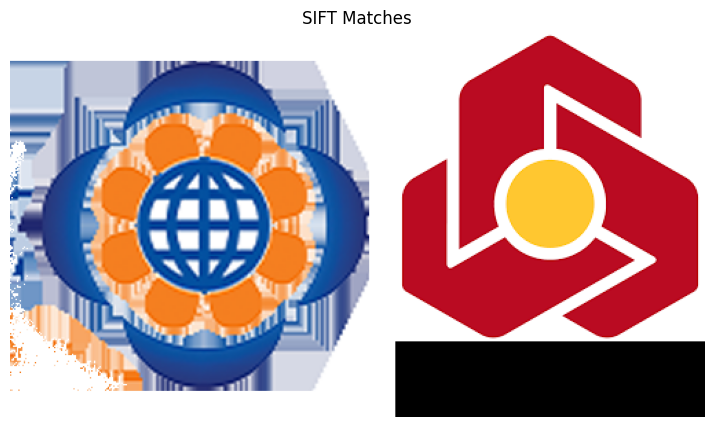

In [37]:
good_matches, kp1, kp2, keypoints1, keypoints2, matches = sift_similarity(img1_path, img2_path)
show_sift_matches(img1_path, img2_path, keypoints1, keypoints2, matches)

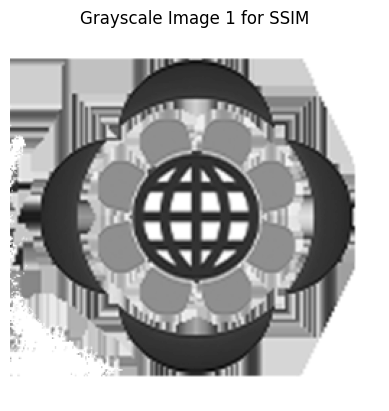

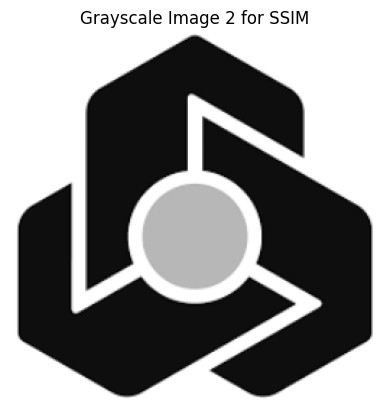

SSIM Score: 0.3049


In [38]:
ssim_score = compute_ssim(img1_path, img2_path)
print(f"SSIM Score: {ssim_score:.4f}")


Number of good matches: 0
Keypoints in Image 1: 878, Image 2: 64
SIFT Match Ratio: 0.0000


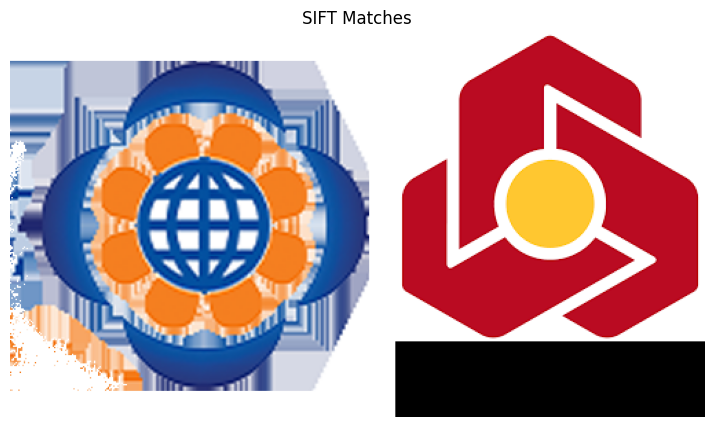

In [39]:
good_matches, kp1, kp2, keypoints1, keypoints2, matches = sift_similarity(img1_path, img2_path)
print(f"Number of good matches: {good_matches}")
print(f"Keypoints in Image 1: {kp1}, Image 2: {kp2}")
print(f"SIFT Match Ratio: {good_matches / min(kp1, kp2):.4f}")
show_sift_matches(img1_path, img2_path, keypoints1, keypoints2, matches)
